# Effect of incorrect model assumptions in modeling a log-linear stochastic process

This document showcases the use of several approaches into modeling a set of data for which the true generating process is known.

### Generating the data

The data follows the log-linear model, i.e. for a vector of inputs $\bar{x}$ the output is drawn from the Poisson distribution with the expected value of $\exp(\bar{\beta} \cdot \bar{x})$, where $\bar{\beta}$ is the parameter vector of the model. We create a sample of two input variables $x_1\in \mathbb{R}$ and $x_2\in \mathbb{N}$, and the corresponding outputs $\bar{y}$. These samples are then split into training set and test set. 

In [69]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as skl
import statsmodels.api as sm


# Sample size                                                                                                                                                           
samples = 1000

## Create the simulated data                                                                                                                                            
# True parameter values                                                                                                                                                 
b0, b1, b2 = 0.1, -0.1, 0.2

# Input variables                                                                                                                                                       
np.random.seed(134)
x1 = np.random.normal(6,3, samples)
x2 = np.random.poisson(12.5, samples)
D = np.stack((x1,x2), axis=1)

# Output variables from log-linear model                                                                                                                                
y = np.random.poisson([np.exp(b0+b1*x1[a]+b2*x2[a]) for a in range(samples)])

The following two plots show the simulated data, as output against each input variable. The blue line shows the expectation level for the mean value of the other input parameter.

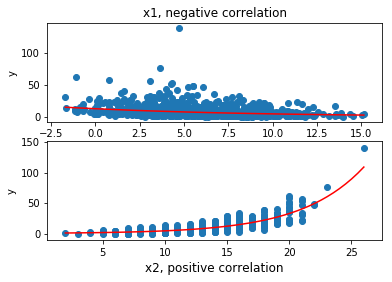

In [83]:
plt.subplot(211)
plt.plot(np.linspace(min(x1), max(x1)), [np.exp(b0+b1*a+b2*np.mean(x2)) for a in np.linspace(min(x1), max(x1))], 'r')
plt.scatter(x1,y)
plt.title('x1, negative correlation')
plt.ylabel("y")
plt.xlabel("x1")
plt.subplot(212)
plt.plot(np.linspace(min(x2), max(x2)), [np.exp(b0+b1*np.mean(x1)+b2*a) for a in np.linspace(min(x2), max(x2))], 'r')
plt.ylabel("y")
plt.scatter(x2,y)
plt.title('x2, positive correlation', y=-.38)
plt.show()

In [71]:
train_X, test_X, train_y, test_y = skl.train_test_split(D, y, test_size=0.5)

The next plots show the split between training and testing sets.

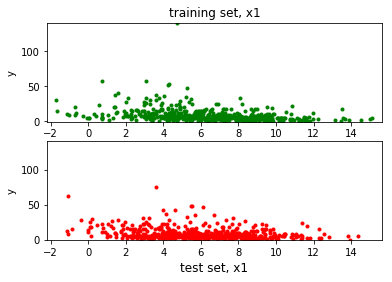

In [89]:
plt.subplot(211)
plt.plot(train_X[:,0],train_y, 'g.')
plt.ylabel("y")
plt.xlabel("x1")
plt.xlim(min(x1)-0.5, max(x1)+0.5)
plt.ylim(min(y)-0.5, max(y)+0.5)
plt.title('training set, x1')
plt.subplot(212)
plt.plot(test_X[:,0],test_y, 'r.')
plt.ylabel("y")
plt.xlim(min(x1)-0.5, max(x1)+0.5)
plt.ylim(min(y)-0.5, max(y)+0.5)
plt.title('test set, x1', y=-0.38)
plt.show()

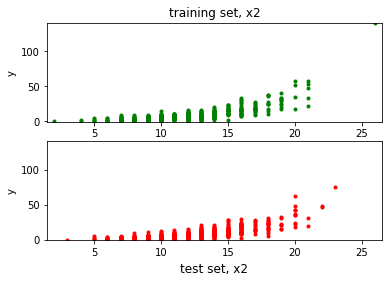

In [86]:
plt.subplot(211)
plt.plot(train_X[:,1],train_y, 'g.')
plt.xlim(min(x2)-0.5, max(x2)+0.5)
plt.ylim(min(y)-0.5, max(y)+0.5)
plt.ylabel("y")
plt.xlabel("x2")
plt.title('training set, x2')
plt.subplot(212)
plt.plot(test_X[:,1],test_y, 'r.')
plt.xlim(min(x2)-0.5, max(x2)+0.5)
plt.ylim(min(y)-0.5, max(y)+0.5)
plt.ylabel("y")
plt.title('test set, x2', y=-0.39)
plt.show()

### Fitting a log-linear model to the data

We start with the model that happens to be the true one.

In [74]:
modelGLM = sm.GLM(train_y, train_X, family=sm.families.Poisson(sm.families.links.log)).fit()
print(modelGLM.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  500
Model:                            GLM   Df Residuals:                      498
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1174.6
Date:                Sun, 02 Jun 2019   Deviance:                       507.74
Time:                        22:52:41   Pearson chi2:                     507.
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0946      0.005    -20.210      0.000      -0.104      -0.085
x2             0.2059      0.002    112.995      0.0

The cofficients from the fit are close to the true values, which is not very surprising.
Let us calculate the mean error in the test set with this model, to get a value we can use to compare the different models. 

In [92]:
print("\nLog-linear model:\nAverage prediction error in the test set is {:0.3f},\nwhich is {:0.1f} % of the mean value of y.".format(
    np.mean(abs(modelGLM.predict(train_X)-train_y)), 
    np.mean(abs(modelGLM.predict(train_X)-train_y))/np.mean(train_y)*100))


Log-linear model:
Average prediction error in the test set is 2.171,
which is 23.8 % of the mean value of y.


### Fitting a linear model

Let us start the wrong models with a simple one, the linear model.

In [93]:
modelLinear = sm.OLS(train_y,train_X).fit()
print(modelLinear.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     671.0
Date:                Sun, 02 Jun 2019   Prob (F-statistic):          4.72e-142
Time:                        23:05:58   Log-Likelihood:                -1691.0
No. Observations:                 500   AIC:                             3386.
Df Residuals:                     498   BIC:                             3394.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.3095      0.091    -14.318      0.0

In [91]:
print("\nLinear model:\nAverage prediction error in the test set is {:0.3f},\nwhich is {:0.1f} % of the mean value of y.".format(
    np.mean(abs(modelLinear.predict(train_X)-train_y)), 
    np.mean(abs(modelLinear.predict(train_X)-train_y))/np.mean(train_y)*100))


Linear model:
Average prediction error in the test set is 3.978,
which is 43.5 % of the mean value of y.


The effectiveness of the linear model is affected quite significantly by the width of the parameter values in the data under scrutiny. Shorter value ranges can often readily be approximated by linear model.